Importing Modules

In [ ]:
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
!pip install pydub
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Making Empty Directories

In [ ]:
os.makedirs('/content/drive/MyDrive/Indian Music Genres/spectrograms3sec')
os.makedirs('/content/drive/MyDrive/Indian Music Genres/spectrograms3sec/train')
os.makedirs('/content/drive/MyDrive/Indian Music Genres/spectrograms3sec/test')

genres = 'bollypop bollyrap ghazal semiclassical sufi'
genres = genres.split()
for g in genres:
  path_audio = os.path.join('/content/drive/MyDrive/Indian Music Genres/audio3sec',f'{g}')
  os.makedirs(path_audio)
  path_train = os.path.join('/content/drive/My Drive/Indian Music Genres/spectrograms3sec/train',f'{g}')
  path_test = os.path.join('/content/drive/My Drive/Indian Music Genres/spectrograms3sec/test',f'{g}')
  os.makedirs(path_train)
  os.makedirs(path_test)

Audio Segmentation

In [ ]:
from pydub import AudioSegment
i = 0
for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('/content/drive/MyDrive/Indian Music Genres',f"{g}")):

    song  =  os.path.join(f'/content/drive/MyDrive/Indian Music Genres/{g}',f'{filename}')
    j = j+1
    for w in range(0,15):
      i = i+1
      #print(i)
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_mp3(song)
      new = newAudio[t1:t2]
      new.export(f'/content/drive/MyDrive/Indian Music Genres/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

Converting into mel spectograms

In [ ]:
genres = 'bollypop bollyrap ghazal semiclassical sufi'
genres = genres.split()
for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('/content/drive/MyDrive/Indian Music Genres/audio3sec',f"{g}")):
    song  =  os.path.join(f'/content/drive/MyDrive/Indian Music Genres/audio3sec/{g}',f'{filename}')
    j = j+1
    print(j)
    y,sr = librosa.load(song,duration=3)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'/content/drive/MyDrive/Indian Music Genres/spectrograms3sec/train/{g}/{g+str(j)}.png')

In [ ]:
directory = "/content/drive/MyDrive/Indian Music Genres/spectrograms3sec/train/"
genres = 'bollypop bollyrap ghazal semiclassical sufi'
genres = genres.split()
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:100]

  for f in test_files:

    shutil.move(directory + f"{g}"+ "/" + f,"/content/drive/MyDrive/Indian Music Genres/spectrograms3sec/test/" + f"{g}")


In [ ]:
train_dir = "/content/drive/MyDrive/Indian Music Genres/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/drive/MyDrive/Indian Music Genres/spectrograms3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)


Found 6845 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


CNN Model

In [ ]:
def GenreModel(input_shape = (288,432,4),classes=5):
  np.random.seed(5)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=9))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=5))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=5))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=5))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=5))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

Training

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
model = GenreModel(input_shape=(288,432,4),classes=5)
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1]) 

model.fit_generator(train_generator,epochs=40,validation_data=vali_generator)

In [ ]:
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1]) 

In [ ]:
model.save("model.h5")

In [ ]:
pip install --upgrade tensorflow keras

In [ ]:
import tensorflow as tf
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, 
                          Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,
                          Dropout)
from keras.models import Model, load_model
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from PIL import Image
import librosa
import numpy as np
import librosa.display
from pydub import AudioSegment
import matplotlib.cm as cm
from matplotlib.colors import Normalize

class_labels = ['bollypop',
 'bollyrap',
 'ghazal',
 'semiclassical',
 'sufi']

model = GenreModel(input_shape=(288,432,4),classes=5)
model.load_weights("/content/drive/MyDrive/Indian Music Genres/model.h5")


def convert_mp3_to_wav(music_file):
  sound = AudioSegment.from_mp3(music_file)
  sound.export("music_file.wav",format="wav")

def extract_relevant(wav_file,t1,t2):
  wav = AudioSegment.from_wav(wav_file)
  wav = wav[1000*t1:1000*t2]
  wav.export("extracted.wav",format='wav')

def create_melspectrogram(wav_file):
  y,sr = librosa.load(wav_file,duration=3)
  mels = librosa.feature.melspectrogram(y=y,sr=sr)

  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
  plt.savefig('melspectrogram.png')

  
def predict(image_data,model):
  image = img_to_array(image_data)
  image = np.reshape(image,(1,288,432,4))
  prediction = model.predict(image/255)
  prediction = prediction.reshape((5,)) 
  class_label = np.argmax(prediction)
  return class_label,prediction

def show_output(songname):
  convert_mp3_to_wav(songname + ".mp3")
  extract_relevant("music_file.wav",50,100)
  create_melspectrogram("extracted.wav") 
  image_data = load_img('melspectrogram.png',color_mode='rgba',target_size=(288,432)) 

  class_label,prediction = predict(image_data,model)

  prediction = prediction.reshape((5,)) 
  
  color_data = [1,2,3,4,5]
  my_cmap = cm.get_cmap('jet')
  my_norm = Normalize(vmin=0, vmax=9)

  fig,ax= plt.subplots(figsize=(6,4.5))
  ax.bar(x=class_labels,height=prediction,
  color=my_cmap(my_norm(color_data)))
  plt.xticks(rotation=45)
  ax.set_title("Percentage Of different Genres")
  plt.show()

1/1 [==============================] - 0s 55ms/step


<ipython-input-14-22dcc4d3c717>:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap('jet')


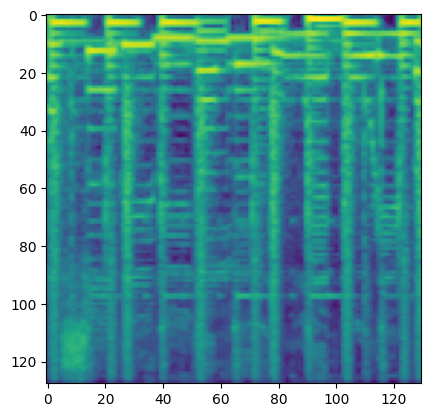

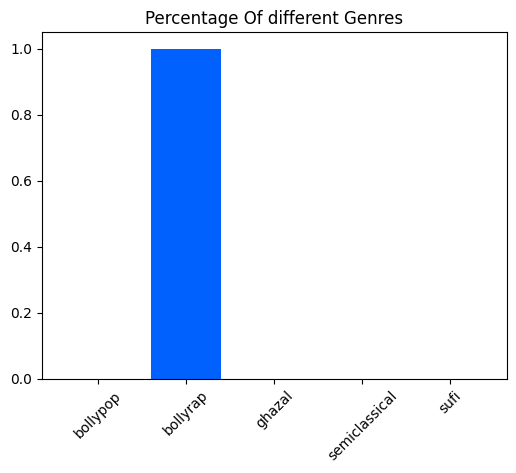

In [ ]:
show_output("/content/drive/MyDrive/Indian Music Genres/Test Samples/She Move It Like - Badshah")